# **Introduction**
### In this task, I am going to optimize the hyperparameters of a machine learning model
### to improve its performance. We will:
### 1. Select a machine learning model (Random Forest).
### 2. Use GridSearchCV, RandomizedSearchCV, and Optuna for hyperparameter tuning.
### 3. Evaluate the model using metrics like accuracy, precision, recall, and F1 score.

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler ,SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
from optuna.pruners import MedianPruner

# **Importing and Preprocessing the Dataset**

In [ ]:
df = pd.read_csv("LoanApprovalPrediction.csv")

# Display first 10 rows
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2.0,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0.0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3.0,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2.0,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1.0,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [ ]:
# Basic information about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            598 non-null    object 
 1   Gender             598 non-null    object 
 2   Married            598 non-null    object 
 3   Dependents         586 non-null    float64
 4   Education          598 non-null    object 
 5   Self_Employed      598 non-null    object 
 6   ApplicantIncome    598 non-null    int64  
 7   CoapplicantIncome  598 non-null    float64
 8   LoanAmount         577 non-null    float64
 9   Loan_Amount_Term   584 non-null    float64
 10  Credit_History     549 non-null    float64
 11  Property_Area      598 non-null    object 
 12  Loan_Status        598 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 60.9+ KB


In [ ]:
# Summary statistics
df.describe()


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,586.000000,598.000000,598.000000,577.000000,584.000000,549.000000
mean,0.755973,5292.252508,1631.499866,144.968804,341.917808,0.843352
std,1.007751,5807.265364,2953.315785,82.704182,65.205994,0.363800
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.000000,1.000000
50%,0.000000,3806.000000,1211.500000,127.000000,360.000000,1.000000
75%,1.750000,5746.000000,2324.000000,167.000000,360.000000,1.000000
max,3.000000,81000.000000,41667.000000,650.000000,480.000000,1.000000


In [ ]:
# Check for missing values
df.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,12
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,21
Loan_Amount_Term,14


# **Data Preprocessing**

In [ ]:
# Select categorical and numerical columns
cat_cols = df.select_dtypes(include="object").columns
num_cols = df.select_dtypes(include=['float', 'int']).columns

print("Categorical columns:", len(cat_cols))
print("Numerical columns:", len(num_cols))

Categorical columns: 7
Numerical columns: 6


In [ ]:
# Fill missing values (mode for categorical, mean for numerical)
null_columns = df.columns[df.isnull().any()].tolist()
for col in null_columns:
    if col != "LoanAmount":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean()).round()


In [ ]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

# **Data Visualization & Balancing Dataset**

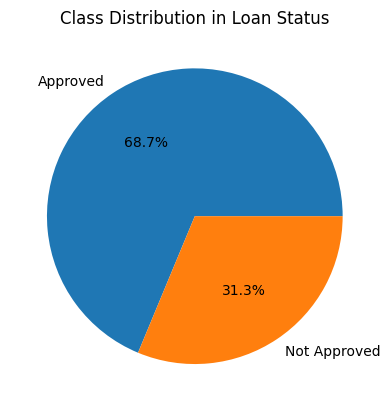

In [ ]:
# Class distribution for the Loan_Status column
class_counts = df["Loan_Status"].value_counts()
def make_pie_chart(counts, label1, label2):
    labels = [label1, label2]
    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title('Class Distribution in Loan Status')
    plt.show()

make_pie_chart(class_counts, 'Approved', 'Not Approved')


In [ ]:
# **Handling Imbalanced Data with Random Over Sampling**
X = df.drop(["Loan_ID", "Loan_Status"], axis=1)
y = df["Loan_Status"]

ros = RandomOverSampler(sampling_strategy="auto")
X_res, y_res = ros.fit_resample(X, y)



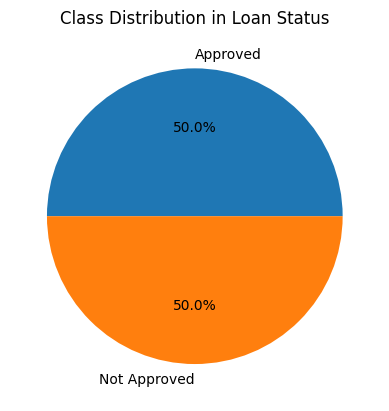

In [ ]:
# Visualizing the oversampled distribution
make_pie_chart(y_res.value_counts(), 'Approved', 'Not Approved')

In [ ]:
df_resampled=X_res.join(y_res)
df_resampled.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,145.0,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Text(0.5, 1.0, 'Gender vs Loan Status')

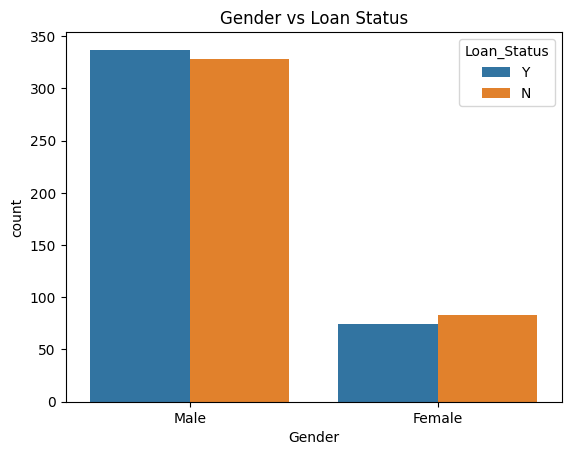

In [ ]:
sns.countplot(x="Gender",hue="Loan_Status",data=df_resampled);
plt.title("Gender vs Loan Status")

Text(0.5, 1.0, 'Education vs Loan Status')

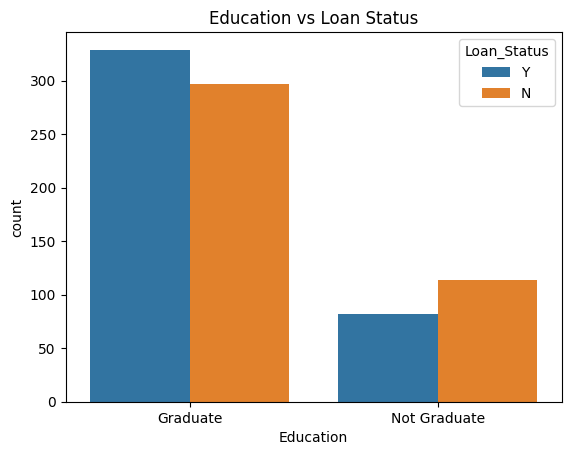

In [ ]:
sns.countplot(x="Education",hue="Loan_Status",data=df_resampled);
plt.title("Education vs Loan Status")

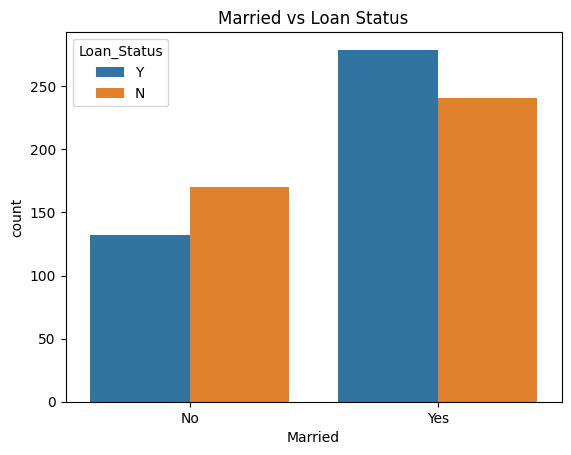

In [ ]:
sns.countplot(x="Married",hue="Loan_Status",data=df_resampled);
plt.title("Married vs Loan Status");

Text(0.5, 1.0, 'Dependents vs Loan Status')

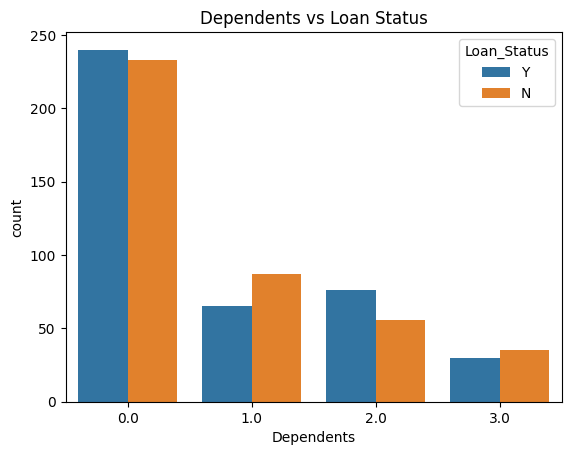

In [ ]:
sns.countplot(x="Dependents",hue="Loan_Status",data=df_resampled);
plt.title("Dependents vs Loan Status")

Text(0.5, 1.0, 'Credit History vs Loan Status')

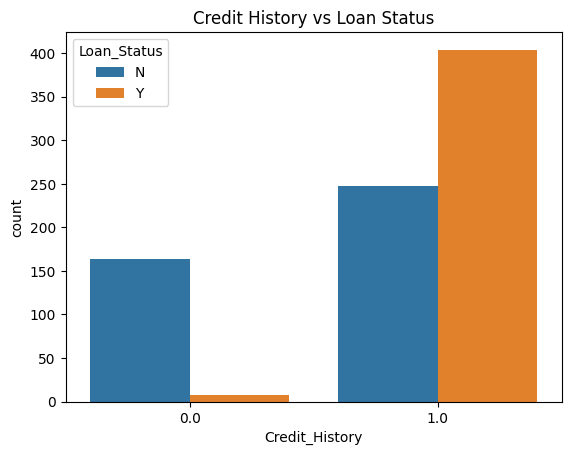

In [ ]:
sns.countplot(x="Credit_History",hue="Loan_Status",data=df_resampled);
plt.title("Credit History vs Loan Status")

# **Feature Engineering**

In [ ]:
cat_cols=df_resampled.select_dtypes(include="object").columns
cat_cols

Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area',
       'Loan_Status'],
      dtype='object')

In [ ]:
encoder=LabelEncoder()
for col in cat_cols:
    df_resampled[col]=encoder.fit_transform(df_resampled[col])

In [ ]:
df_resampled["Total_Income"] = df_resampled["ApplicantIncome"] + df_resampled["CoapplicantIncome"]
df_resampled['StableIncome'] = (df_resampled['ApplicantIncome'] > df_resampled['ApplicantIncome'].median()).astype(int)
df_resampled["Income_to_loanRatio"] = (df_resampled["Total_Income"] / df_resampled["LoanAmount"]).round(2)
df_resampled["Dept_to_IncomeRation"] = (df_resampled["LoanAmount"]) / df_resampled["Total_Income"].round(2)


<Axes: >

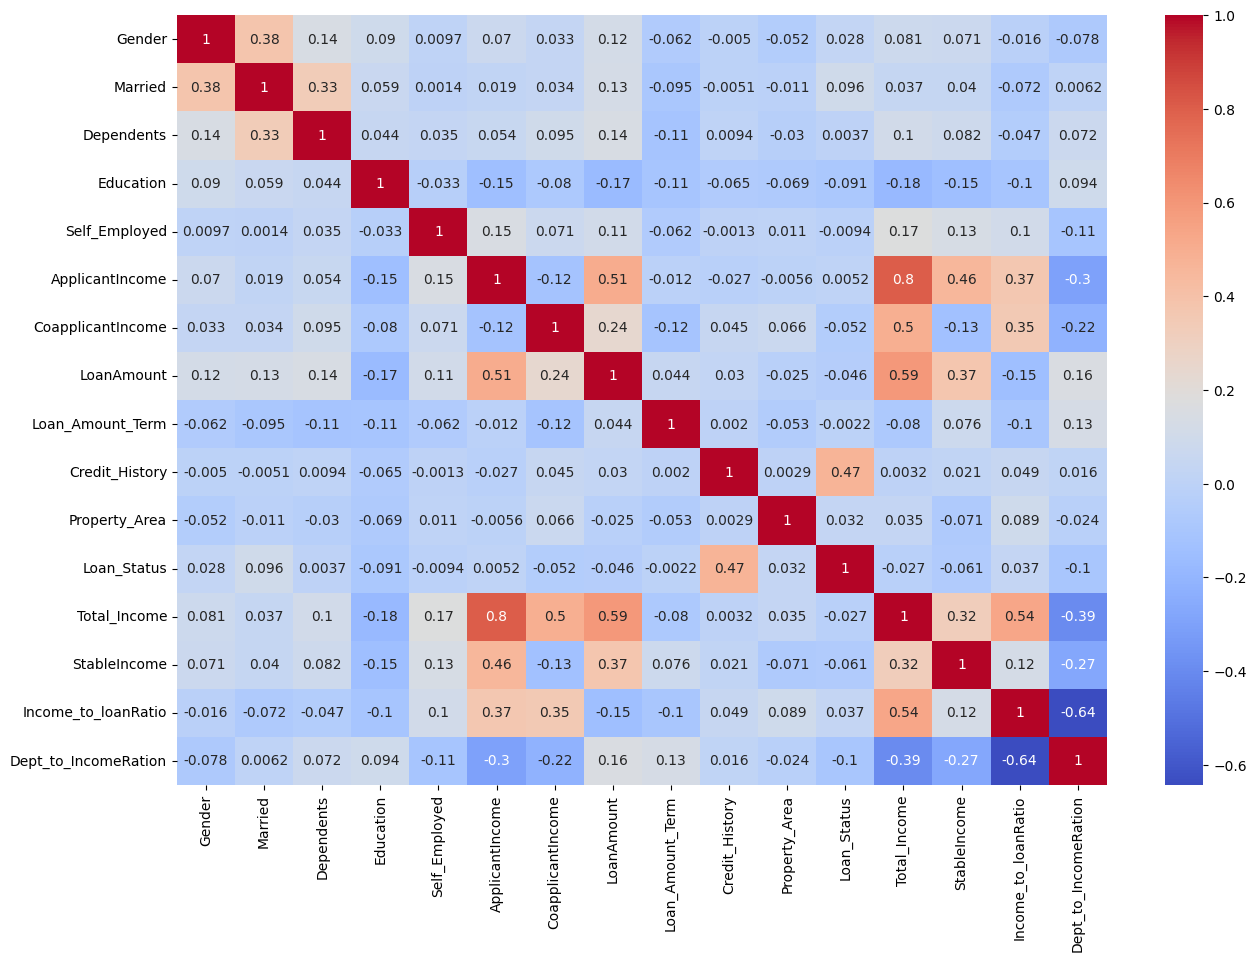

In [ ]:
# Correlation matrix
plt.figure(figsize=(15, 10))
correlation = df_resampled.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")

# **Selecting Important Features**

In [ ]:
selected_col = {}
for col in df_resampled.columns:
    corr = df_resampled[col].corr(df_resampled["Loan_Status"])
    if (corr > 0.01) or (corr < -0.01):
        selected_col[col] = corr

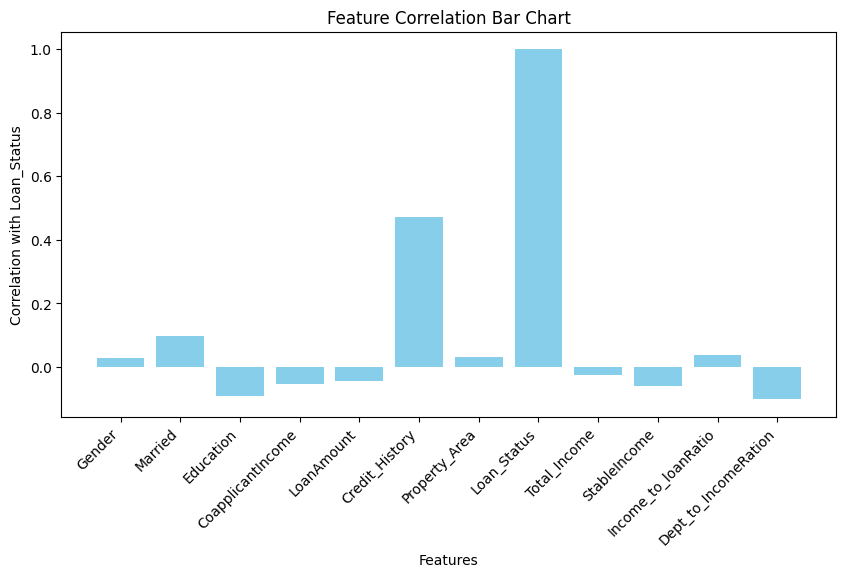

In [ ]:
# Display feature correlation
x_values = list(selected_col.keys())
y_values = list(selected_col.values())
plt.figure(figsize=(10, 5))
plt.bar(x_values, y_values, color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Correlation with Loan_Status")
plt.title("Feature Correlation Bar Chart")
plt.show()


In [ ]:
selected_col

{'Gender': 0.027853633741398362,
 'Married': 0.09589113372066974,
 'Education': -0.09135551622599233,
 'CoapplicantIncome': -0.05235245820382717,
 'LoanAmount': -0.045837027535348636,
 'Credit_History': 0.47055576976420804,
 'Property_Area': 0.03156809875819208,
 'Loan_Status': 1.0,
 'Total_Income': -0.026831107923938002,
 'StableIncome': -0.060827250608272515,
 'Income_to_loanRatio': 0.03671999611119622,
 'Dept_to_IncomeRation': -0.10129592379281137}

In [ ]:
# Select only the important features for the final model
df_resampled = df_resampled[x_values]

# # Drop unneeded columns
df_resampled.drop(["CoapplicantIncome"], axis=1, inplace=True)


<ipython-input-144-4507b9bd0d83>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled.drop(["CoapplicantIncome"], axis=1, inplace=True)


# **Splitting data into training and testing Sets**

In [ ]:
# Define the target and features
X = df_resampled.drop("Loan_Status", axis=1)
y = df_resampled["Loan_Status"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Training Random Forest Model and Evaluating Performance**

Accuracy: 0.8848
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        82
           1       0.94      0.82      0.88        83

    accuracy                           0.88       165
   macro avg       0.89      0.89      0.88       165
weighted avg       0.89      0.88      0.88       165



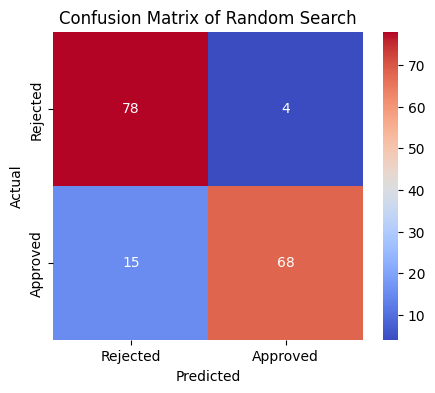

In [ ]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {rf_acc:.4f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Random Search")
plt.show()

# **Hyperparameter Tuning with GridSearchCV**

In [ ]:

param_grid = {
    'n_estimators': [100,150],
    'max_depth': [10,18,20,None],
    'min_samples_split': [1,2,5],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['entropy','gini'],
    'max_features': ['log2','sqrt',None],
    'bootstrap': [False,True]

}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/u

Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.8812861438815638


In [ ]:
# Get the best model directly
grid_search_best_model = grid_search.best_estimator_

Accuracy: 0.8909
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        82
           1       0.93      0.84      0.89        83

    accuracy                           0.89       165
   macro avg       0.89      0.89      0.89       165
weighted avg       0.89      0.89      0.89       165



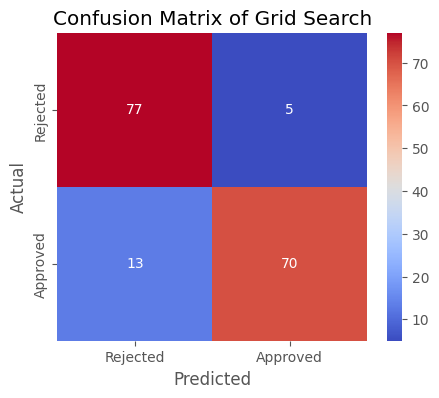

In [ ]:
y_pred = grid_search_best_model.predict(X_test)
gs_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {gs_acc:.4f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Grid Search")
plt.show()

# **Hyperparameter Tuning with RandomizedSearchCV**

In [ ]:
param_distributions = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['log2', 'sqrt', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
Best Score: 0.8401919962988667


In [ ]:
# Get the best model directly
random_search_best_model = random_search.best_estimator_

Accuracy: 0.8121
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        82
           1       0.82      0.80      0.81        83

    accuracy                           0.81       165
   macro avg       0.81      0.81      0.81       165
weighted avg       0.81      0.81      0.81       165



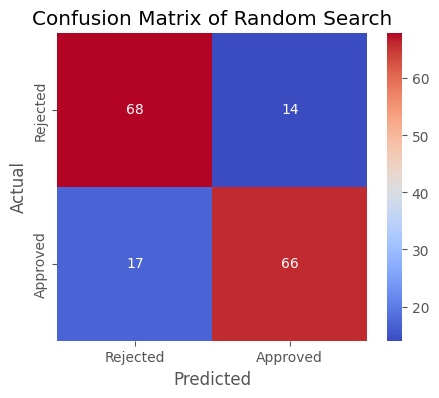

In [ ]:
y_pred = random_search_best_model.predict(X_test)
rs_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {rs_acc:.4f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Random Search")
plt.show()

# **Hyperparameter Tuning with Optuna**

In [ ]:
def objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        max_depth=trial.suggest_int('max_depth', 2, 20),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
        max_features=trial.suggest_categorical('max_features', ['log2','sqrt', None]),
        bootstrap=trial.suggest_categorical('bootstrap', [False,True]),
        random_state=42
    )
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

study = optuna.create_study(direction='maximize',pruner=MedianPruner())
study.optimize(objective, n_trials=500)

print("Best Trial:", study.best_trial.params)

[I 2025-02-18 18:18:23,418] A new study created in memory with name: no-name-2b823ad4-251c-4f65-9152-db3f6295a111
[I 2025-02-18 18:18:23,584] Trial 0 finished with value: 0.7636363636363637 and parameters: {'n_estimators': 105, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.7636363636363637.
[I 2025-02-18 18:18:23,696] Trial 1 finished with value: 0.7515151515151515 and parameters: {'n_estimators': 72, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.7636363636363637.
[I 2025-02-18 18:18:23,800] Trial 2 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 53, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 19, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.7636363636363637.
[I 2025-02-18 18:18:24,026] Trial 3 finished with value: 0.75151515151515

Best Trial: {'n_estimators': 152, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}


<ipython-input-149-200bf0662a9e>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
<ipython-input-149-200bf0662a9e>:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

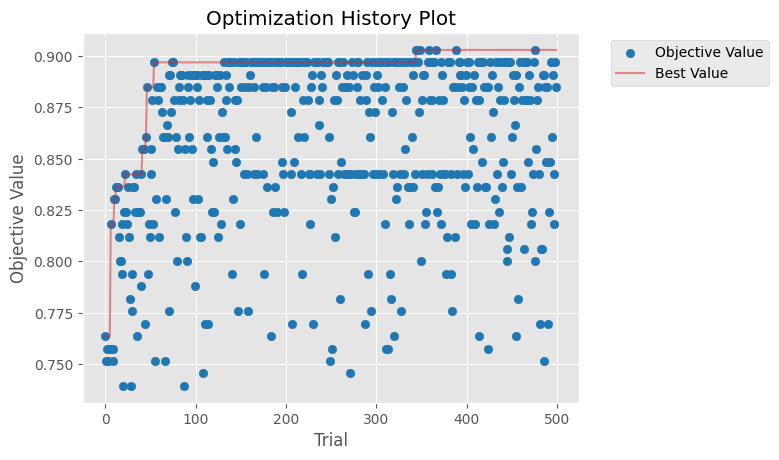

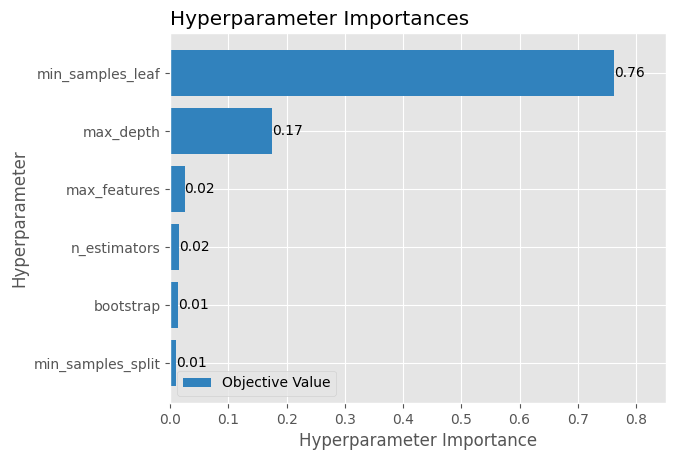

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_param_importances(study)

In [ ]:
optuna_best_model = RandomForestClassifier(
    n_estimators=152,
    max_depth=18,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='log2',
    bootstrap=False,
    random_state=42
)

optuna_best_model.fit(X_train, y_train)
y_pred = optuna_best_model.predict(X_test)

Accuracy: 0.9030
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        82
           1       0.95      0.86      0.90        83

    accuracy                           0.90       165
   macro avg       0.91      0.90      0.90       165
weighted avg       0.91      0.90      0.90       165



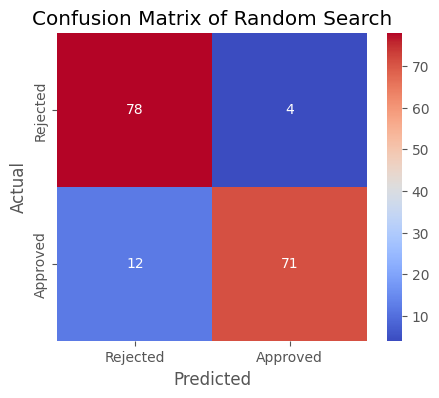

In [ ]:
optuna_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {optuna_acc:.4f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Random Search")
plt.show()


# **Best Model Selection and Saving**

Best Model: Optuna with Accuracy: 0.9030


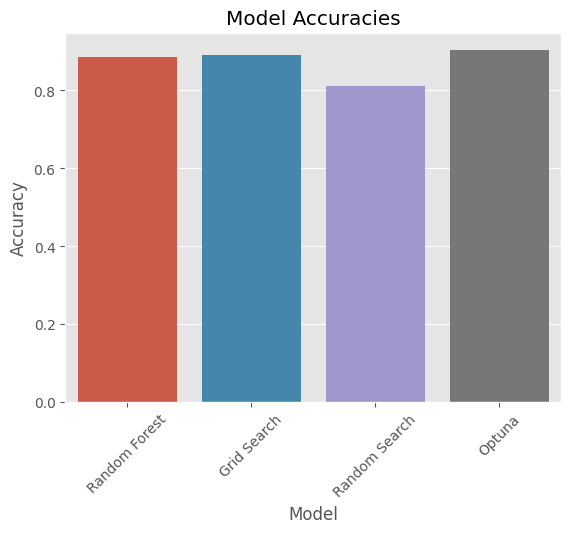

Saved Optuna as 'Optuna_best_model.pkl'


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving the model

# Dictionary of model accuracies
model_accuracies = {
    "Random Forest": rf_acc,
    "Grid Search": gs_acc,
    "Random Search": rs_acc,
    "Optuna": optuna_acc
}

# Find the best model
best_model_name = max(model_accuracies, key=model_accuracies.get)
print(f"Best Model: {best_model_name} with Accuracy: {model_accuracies[best_model_name]:.4f}")

# Bar plot
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()),hue=model_accuracies.keys())
plt.xticks(rotation=45)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.show()

# Save the best model
if best_model_name == "Random Forest":
    best_model = rf_model
elif best_model_name == "Grid Search":
    best_model = grid_search_best_model
elif best_model_name == "Random Search":
    best_model = random_search_best_model
elif best_model_name == "Optuna":
    best_model = optuna_best_model

# Save the best model to a file
joblib.dump(best_model, f"{best_model_name}_best_model.pkl")
print(f"Saved {best_model_name} as '{best_model_name}_best_model.pkl'")



# Conclusion  

The **Loan Approval Prediction** model was successfully developed and optimized.  

- **Initial Model Accuracy (Before Hyperparameter Tuning):** 88.48%  
- **Final Model Accuracy (After Hyperparameter Tuning):** 90.30%  
- **Feature Engineering** helped improve predictive performance.  
- The best-performing model was found using **Optuna/GridSearchCV**.  
- The trained model is now saved and ready for real-world predictions.  

This project demonstrates effective **data preprocessing, feature engineering, model training,** and **performance optimization** techniques in machine learning.  
